## 1. 导入必要库，选择场类型

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import os
import sys
from pathlib import Path
from typing import Optional, Tuple, List, Dict, Any, Union

# 导入 Lightning Fabric
from lightning import Fabric

# 导入 PyTorch Geometric 相关
from torch_geometric.utils import to_dense_batch

# 设置项目路径
project_root = Path(os.getcwd()).parent
sys.path.insert(0, str(project_root))

# 导入项目相关模块
from funcmol.utils.constants import PADDING_INDEX
from funcmol.utils.utils_nf import create_neural_field, load_neural_field
from funcmol.utils.gnf_converter import GNFConverter
from funcmol.dataset.dataset_field import create_field_loaders

# 导入 Hydra
import hydra

# 导入可视化函数
from gnf_visualizer import GNFVisualizer, MoleculeMetrics, visualize_reconstruction

# 设置 torch.compile 兼容性
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [20]:
# 1表示使用标准答案gt，2表示使用预测场predicted
FIELD_OPTION = 2

In [21]:
fabric = Fabric(
    accelerator="cpu",
    devices=1,
    precision="32-true",
    strategy="auto"
)
fabric.launch()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

config_dir = str(Path.cwd().parent / "configs")
with hydra.initialize_config_dir(config_dir=config_dir, version_base=None):
    config = hydra.compose(config_name="train_nf_qm9")

# 在这里修改数据路径
config["dset"]["data_dir"] = str(Path.cwd().parent / "dataset" / "data")

enc, dec = create_neural_field(config, fabric)
enc = enc.to(device)
dec = dec.to(device)

loader_val = create_field_loaders(config, split="val", fabric=fabric)
batch = next(iter(loader_val)).to(device)
coords, _ = to_dense_batch(batch.pos, batch.batch, fill_value=0)
atoms_channel, _ = to_dense_batch(batch.x, batch.batch, fill_value=PADDING_INDEX)
gt_coords = coords
gt_types = atoms_channel

converter = GNFConverter(
    sigma=config["converter"]["sigma"],
    n_query_points=config["converter"]["n_query_points"],
    n_iter=config["converter"]["n_iter"],
    step_size=config["converter"]["step_size"],
    eps=config["converter"]["eps"],
    min_samples=config["converter"]["min_samples"],
    device=device,
    sigma_ratios=config["converter"]["sigma_ratios"],
    version=config["converter"]["version"],
    temperature=config["converter"]["temperature"]
)

with torch.no_grad():
    codes = enc(batch)

>> val set size: 20042


In [22]:
results = visualize_reconstruction(gt_coords, gt_types, converter, dec, codes)


Starting reconstruction for molecule 0
Ground truth atoms: 4
Atom types: [0, 2, 1, 1]
Iteration 0, Atom type 0: grad norm = 0.957486
Iteration 0, Atom type 1: grad norm = 0.914320
Iteration 0, Atom type 2: grad norm = 0.972622
Iteration 0, Atom type 3: grad norm = 0.000000
Iteration 0, Atom type 4: grad norm = 0.000000
Iteration 1000, Atom type 0: grad norm = 0.047456
Iteration 1000, Atom type 1: grad norm = 0.045356
Iteration 1000, Atom type 2: grad norm = 0.048206
Iteration 1000, Atom type 3: grad norm = 0.000000
Iteration 1000, Atom type 4: grad norm = 0.000000
[DBSCAN] Total points: 500, Clusters found: 1, Noise points: 0
[DBSCAN] Total points: 500, Clusters found: 2, Noise points: 0
[DBSCAN] Total points: 500, Clusters found: 1, Noise points: 0
[DBSCAN] Total points: 500, Clusters found: 0, Noise points: 500
[DBSCAN] Total points: 500, Clusters found: 0, Noise points: 500


## 可视化一维梯度场

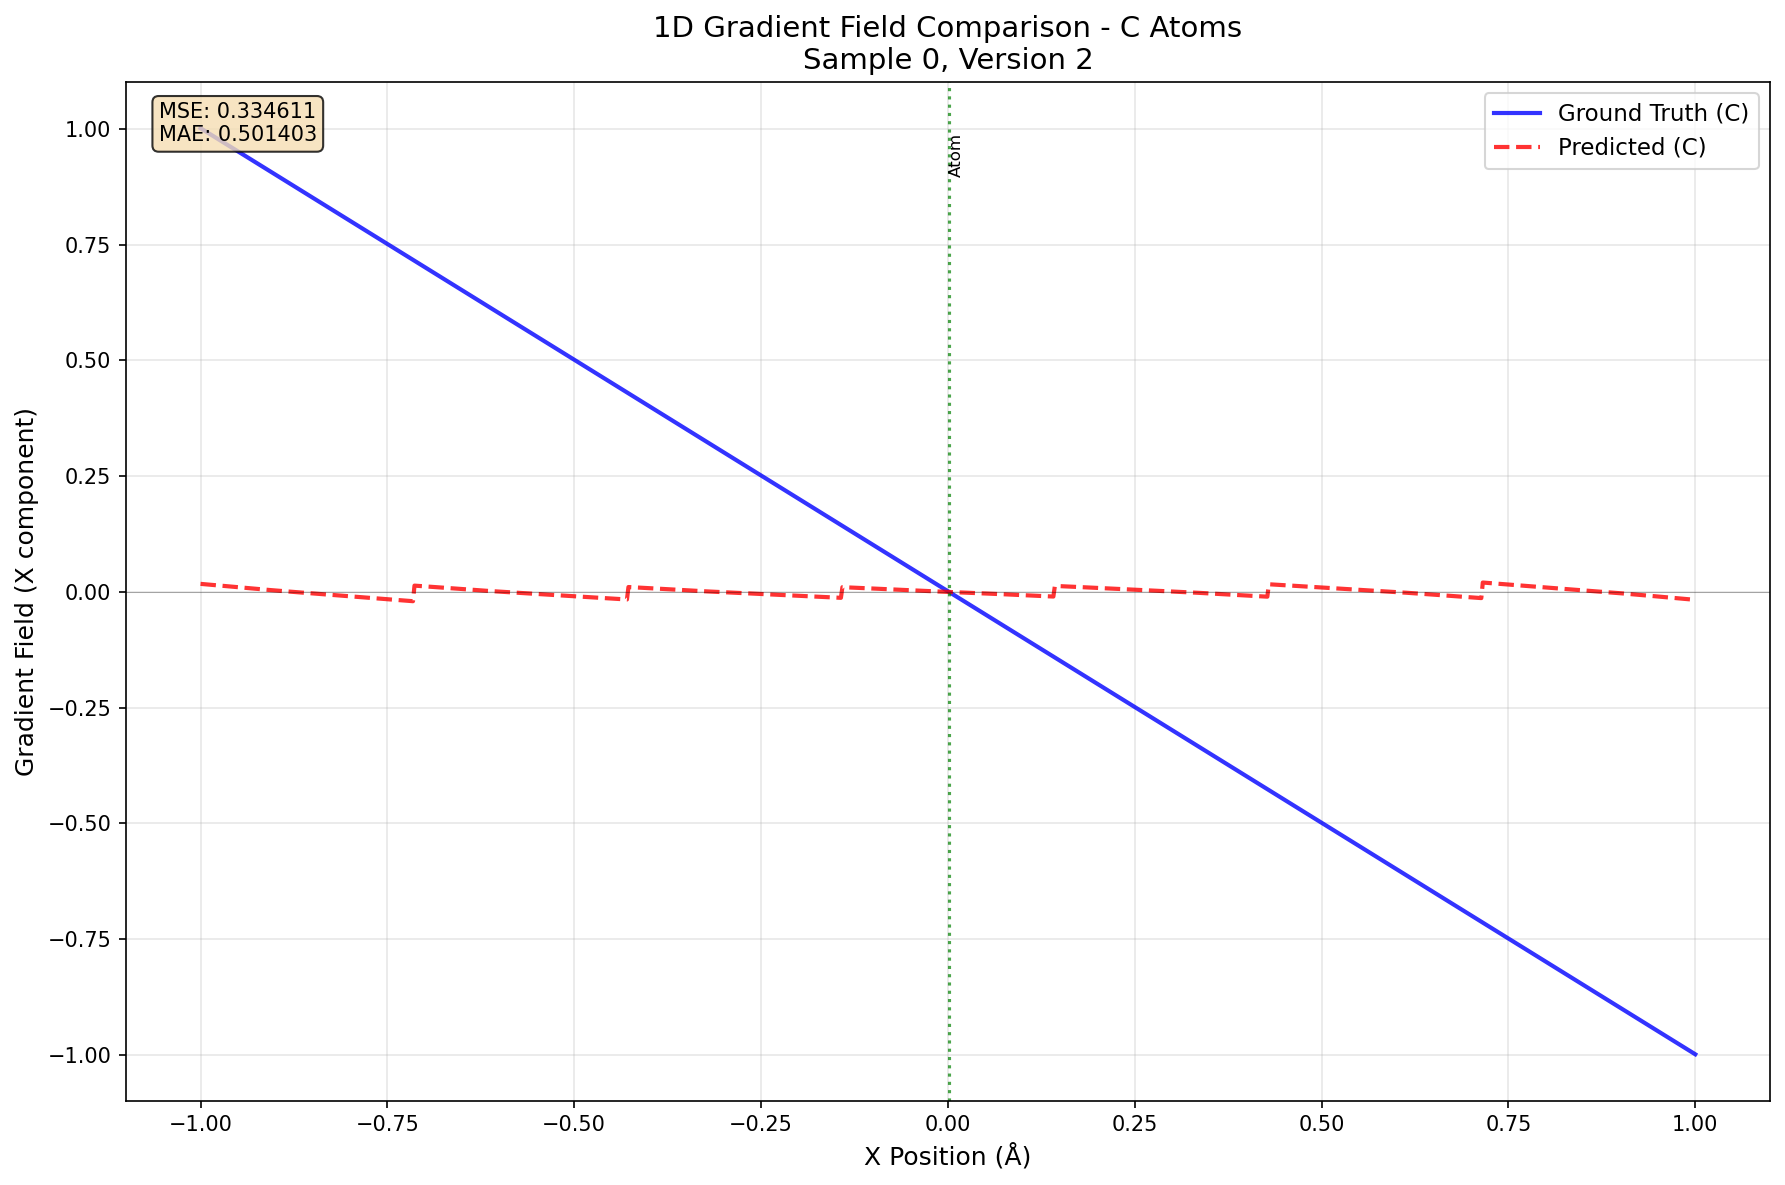


=== 梯度场对比统计 ===
原子类型: C
样本索引: 0
真实原子数量: 4
目标原子数量: 1
MSE: 0.334611
MAE: 0.501403
梯度场范围 - 真实: [-0.9987, 1.0013]
梯度场范围 - 预测: [-0.0202, 0.0201]


In [23]:
def visualize_1d_gradient_field_comparison(
    gt_coords: torch.Tensor,
    gt_types: torch.Tensor,
    converter: GNFConverter,
    decoder: torch.nn.Module,
    codes: torch.Tensor,
    sample_idx: int = 0,
    atom_type: int = 0,  # 0=C, 1=H, 2=O, 3=N, 4=F
    x_range: tuple = (-10, 10),
    n_points: int = 1000
):
    """
    可视化一维方向上的梯度场对比
    
    Args:
        gt_coords: 真实分子坐标 [batch, n_atoms, 3]
        gt_types: 真实原子类型 [batch, n_atoms]
        converter: GNF转换器
        decoder: 解码器模型
        codes: 编码器输出的codes [batch, code_dim]
        sample_idx: 要可视化的样本索引
        atom_type: 要可视化的原子类型 (0=C, 1=H, 2=O, 3=N, 4=F)
        x_range: x轴范围
        n_points: 采样点数
    """
    device = gt_coords.device
    
    # 获取当前样本的有效原子
    gt_mask = (gt_types[sample_idx] != PADDING_INDEX)
    gt_valid_coords = gt_coords[sample_idx][gt_mask]
    gt_valid_types = gt_types[sample_idx][gt_mask]
    
    # 创建一维采样点 (沿x轴)
    x = torch.linspace(x_range[0], x_range[1], n_points, device=device)
    query_points = torch.zeros(n_points, 3, device=device)
    query_points[:, 0] = x  # 只在x轴方向变化
    
    # 计算标准答案梯度场 (version 2)
    with torch.no_grad():
        gt_field = converter.mol2gnf(
            gt_valid_coords.unsqueeze(0),
            gt_valid_types.unsqueeze(0),
            query_points.unsqueeze(0)
        )
        gt_gradients = gt_field[0, :, atom_type, 0]  # 取x方向分量
    
    # 计算预测梯度场
    with torch.no_grad():
        pred_field = decoder(query_points.unsqueeze(0), codes[sample_idx:sample_idx+1])
        pred_gradients = pred_field[0, :, atom_type, 0]  # 取x方向分量
    
    # 创建可视化
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # 绘制梯度场
    ax.plot(x.cpu().numpy(), gt_gradients.cpu().numpy(), 
            label=f'Ground Truth ({["C", "H", "O", "N", "F"][atom_type]})', 
            linewidth=2, color='blue', alpha=0.8)
    ax.plot(x.cpu().numpy(), pred_gradients.cpu().numpy(), 
            label=f'Predicted ({["C", "H", "O", "N", "F"][atom_type]})', 
            linewidth=2, color='red', alpha=0.8, linestyle='--')
    
    # 标记原子位置
    atom_positions = gt_valid_coords[gt_valid_types == atom_type, 0].cpu().numpy()
    if len(atom_positions) > 0:
        for pos in atom_positions:
            ax.axvline(x=pos, color='green', linestyle=':', alpha=0.7, linewidth=1.5)
            ax.text(pos, ax.get_ylim()[1] * 0.9, f'Atom', 
                   rotation=90, verticalalignment='top', fontsize=8)
    
    # 添加零线
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
    
    # 设置图表属性
    ax.set_xlabel('X Position (Å)', fontsize=12)
    ax.set_ylabel('Gradient Field (X component)', fontsize=12)
    ax.set_title(f'1D Gradient Field Comparison - {["C", "H", "O", "N", "F"][atom_type]} Atoms\n'
                f'Sample {sample_idx}, Version 2', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    
    # 计算并显示误差
    mse = torch.mean((gt_gradients - pred_gradients) ** 2).item()
    mae = torch.mean(torch.abs(gt_gradients - pred_gradients)).item()
    
    ax.text(0.02, 0.98, f'MSE: {mse:.6f}\nMAE: {mae:.6f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"\n=== 梯度场对比统计 ===")
    print(f"原子类型: {['C', 'H', 'O', 'N', 'F'][atom_type]}")
    print(f"样本索引: {sample_idx}")
    print(f"真实原子数量: {len(gt_valid_coords)}")
    print(f"目标原子数量: {(gt_valid_types == atom_type).sum().item()}")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"梯度场范围 - 真实: [{gt_gradients.min().item():.4f}, {gt_gradients.max().item():.4f}]")
    print(f"梯度场范围 - 预测: [{pred_gradients.min().item():.4f}, {pred_gradients.max().item():.4f}]")
    
    return {
        'x': x.cpu().numpy(),
        'gt_gradients': gt_gradients.cpu().numpy(),
        'pred_gradients': pred_gradients.cpu().numpy(),
        'mse': mse,
        'mae': mae
    }

results = visualize_1d_gradient_field_comparison(
    gt_coords=gt_coords,
    gt_types=gt_types, 
    converter=converter,
    decoder=dec,
    codes=codes,
    sample_idx=0,        # 选择qm9里的第几个样本
    atom_type=0,         # 可视化哪种原子，可以选0-4 (0=C, 1=H, 2=O, 3=N, 4=F)
    x_range=(-1, 1),     # x轴范围
    n_points=1000         # 采样点数
)